In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt

import torch

torch.set_default_dtype(torch.float32)

import ehtim as eh # eht imaging package

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from generative_model import glow_model
from generative_model import realnvpfc_model
from DPI_interferometry import Img_logscale

Welcome to eht-imaging! v 1.2.2 



# Load the learned DPI normalizing flow for VLBI

In [2]:
# load obs file
obs_path = '../../dataset/interferometry1/obs.uvfits'
obs = eh.obsdata.load_uvfits(obs_path)
flux_const = np.median(obs.unpack_bl('APEX', 'ALMA', 'amp')['amp'])

# define the normalizing flow network
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
npix = 32
n_flow = 16
affine = True
img_generator = realnvpfc_model.RealNVP(npix*npix, n_flow, affine=affine).to(device)
logscale_factor = Img_logscale(scale=flux_const/(0.8*npix*npix)).to(device)

generator_file = '../checkpoint/interferometry_run1/generativemodel_realnvp_res32flow16logdet1.0_closure_fluxcentermemtsv'
logscale_file = '../checkpoint/interferometry_run1/generativescale_realnvp_res32flow16logdet1.0_closure_fluxcentermemtsv'
img_generator.load_state_dict(torch.load(generator_file, map_location=device))
logscale_factor.load_state_dict(torch.load(logscale_file, map_location=device))

Loading uvfits:  ../../dataset/interferometry1/obs.uvfits
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


/home/abao/anaconda3/envs/dpi_torch_dev/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


<All keys matched successfully>

In [3]:
# # switch to inference mode
# logscale_factor.eval()
# img_generator.eval()

# print model summary
print(img_generator)
# print(logscale_factor)

RealNVP(
  (blocks): ModuleList(
    (0): Flow(
      (actnorm): ActNorm()
      (actnorm2): ActNorm()
      (coupling): AffineCoupling(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchNorm1d(128, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
          (3): Linear(in_features=128, out_features=128, bias=True)
          (4): LeakyReLU(negative_slope=0.01, inplace=True)
          (5): BatchNorm1d(128, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
          (6): ZeroFC(
            (fc): Linear(in_features=128, out_features=1024, bias=True)
          )
        )
      )
      (coupling2): AffineCoupling(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=128, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchNorm1d(128, eps=0.01, momentum=0.1, affine=True, track_

## Examine Loss Curves

In [38]:
loss_file = '../checkpoint/interferometry_run1/loss_realnvp_res32flow16logdet1.0_closure_fluxcentermemtsv.npy'

In [39]:
losses = np.load(loss_file, allow_pickle=True)

In [40]:
losses_dict = losses.item()
print(losses_dict)

{'total': array([532.81818957, 524.98904537, 573.02339364, ...,  37.64603237,
        37.64376805,  37.93840996]), 'cphase': array([194.84196459, 193.27718108, 216.30091944, ...,   1.01553411,
         0.98315967,   1.03284031]), 'logca': array([258.4144306 , 252.67326778, 272.08993535, ...,   1.11964736,
         1.12728503,   1.18966204]), 'visamp': array([0, 0, 0, ..., 0, 0, 0]), 'logdet': array([6.79858446, 6.79934311, 6.79717445, ..., 7.55933571, 7.5583601 ,
       7.58516884]), 'flux': array([1.4592758e-03, 1.6632142e-03, 2.5399253e-03, ..., 4.4528257e-05,
       3.9331397e-05, 6.0133985e-05], dtype=float32), 'tsv': array([6.7587066e-06, 6.8443323e-06, 6.6839225e-06, ..., 5.2482801e-06,
       5.2381720e-06, 5.4554484e-06], dtype=float32), 'center': array([0.03992802, 0.03579486, 0.03823848, ..., 0.00075549, 0.0010455 ,
       0.00161456], dtype=float32), 'mem': array([0.00549693, 0.00547132, 0.00547036, ..., 0.00169649, 0.00170639,
       0.00166696], dtype=float32), 'l1': array

In [41]:
def plot_loss_curve(loss_np, loss_label, xscale='linear', yscale='linear'):
    n_epochs = len(loss_np)
    epochs = np.arange(0, n_epochs)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_np)
    plt.xlabel("Epoch")
    plt.ylabel(loss_label)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()
    
def plot_multiple_losses(losses_dict, losses_names, xscale='linear', yscale='linear'):
    plt.figure(figsize=(10, 6))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xscale(xscale)
    plt.yscale(yscale)
    for i in range(len(losses_names)):
        label = losses_names[i]
        loss = losses_dict[label]
        n_epochs = len(loss)
        epochs = np.arange(0, n_epochs)
        plt.plot(epochs, loss, label=label)
    plt.legend()
    plt.show()


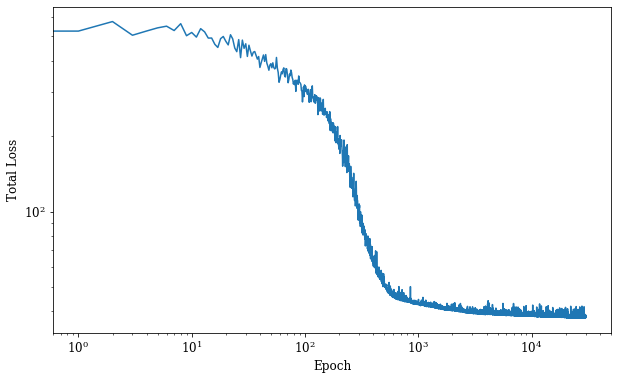

In [46]:
plot_loss_curve(losses_dict['total'], "Total Loss", xscale='log', yscale='log')

In [9]:
losses_names = list(losses_dict.keys())

/home/abao/anaconda3/envs/dpi_torch_dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


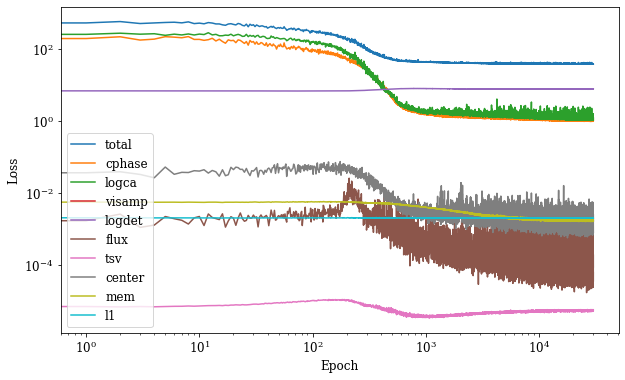

In [10]:
plot_multiple_losses(losses_dict, losses_names, xscale='log', yscale='log')

In [11]:
print("Loss values at last epoch:")
for loss_name, loss_val in losses_dict.items():
    print("{}: {}".format(loss_name, loss_val[-1]))

Loss values at last epoch:
total: 37.93840995934035
cphase: 1.0328403136290918
logca: 1.189662037803156
visamp: 0
logdet: 7.585168838500977
flux: 6.01339852437377e-05
tsv: 5.455448444990907e-06
center: 0.0016145561821758747
mem: 0.0016669620526954532
l1: 0.0019974480383098125


## Examine Prior and Ground Truth

In [12]:
fov = 160 # field of view of the image in micro-arcsecond
prior_fwhm = 50 # fwhm of image prior in micro-arcsecond


# gt_path = '../../dataset/interferometry1/gt.fits'
# simim_gt = eh.image.load_fits(gt_path)
# simim_gt = simim_gt.regrid_image(fov, npix)
# print(simim_gt)

# # plt.figure(figsize = (15,15))
# # plt.imshow(simim_gt)
# # plt.title('Ground Truth')

In [13]:
obs = eh.obsdata.load_uvfits(obs_path)

# define the prior image for MEM regularizer
flux_const = np.median(obs.unpack_bl('APEX', 'ALMA', 'amp')['amp'])
prior_fwhm = prior_fwhm*eh.RADPERUAS#60*eh.RADPERUAS#
fov = fov*eh.RADPERUAS
zbl = flux_const#2.0#0.8#
prior = eh.image.make_square(obs, npix, fov).add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(zbl*1e-6, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

simim = prior.copy()

# simim = eh.image.load_fits(gt_path)
# simim = simim.regrid_image(fov, npix)
simim.ra = obs.ra
simim.dec = obs.dec
simim.rf = obs.rf

Loading uvfits:  ../../dataset/interferometry1/obs.uvfits
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


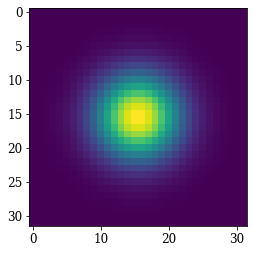

In [14]:
prior_im = torch.Tensor(np.array(prior.imvec.reshape((npix, npix)))).to(device=device)
plt.imshow(prior_im)

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

updated self.camp: no averaging
updated self.camp: avg_time 0.000000 s

updated self.lcamp: no averaging
updated self.logcamp: avg_time 0.000000 s



Text(0.5, 0, 'counts')

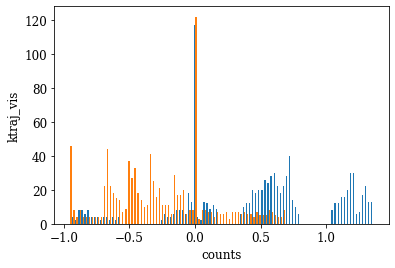

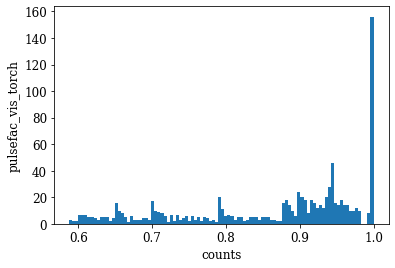

In [15]:
from ehtim.observing.obs_helpers import *
from interferometry_helpers import *
from torchkbnufft import KbNufft, AdjKbNufft
# define the eht observation function
nufft_ob = KbNufft(im_size=(npix, npix), numpoints=3)
ktraj_vis, pulsefac_vis_torch, cphase_ind_list, cphase_sign_list, camp_ind_list = Obs_params_torch(obs, simim)
eht_obs_torch = eht_observation_pytorch(npix, nufft_ob, ktraj_vis, pulsefac_vis_torch, cphase_ind_list, cphase_sign_list, camp_ind_list, device)

plt.figure(figsize=(6,4))
plt.hist(ktraj_vis[0,], bins=100)
plt.ylabel("ktraj_vis")
plt.xlabel("counts")

plt.figure(figsize=(6,4))
plt.hist(pulsefac_vis_torch[0,], bins=100)
plt.ylabel("pulsefac_vis_torch")
plt.xlabel("counts")

# Generate and plot image samples

In [16]:
# generate image samples
n_sample = 1024#32#128#
z_sample = torch.randn(n_sample, npix*npix).to(device=device)

# plt.imshow(z_sample)

# generate image samples
img_samp, logdet = img_generator.reverse(z_sample)

img_samp = img_samp.reshape((-1, npix, npix))

# apply scale factor and sigmoid/softplus layer for positivity constraint
logscale_factor_value = logscale_factor.forward()
scale_factor = torch.exp(logscale_factor_value)
img = torch.nn.Softplus()(img_samp) * scale_factor
image = img.detach().cpu().numpy()

print(image.shape)

(1024, 32, 32)


Text(0.5, 1.0, 'DPI generated VLBI image samples')

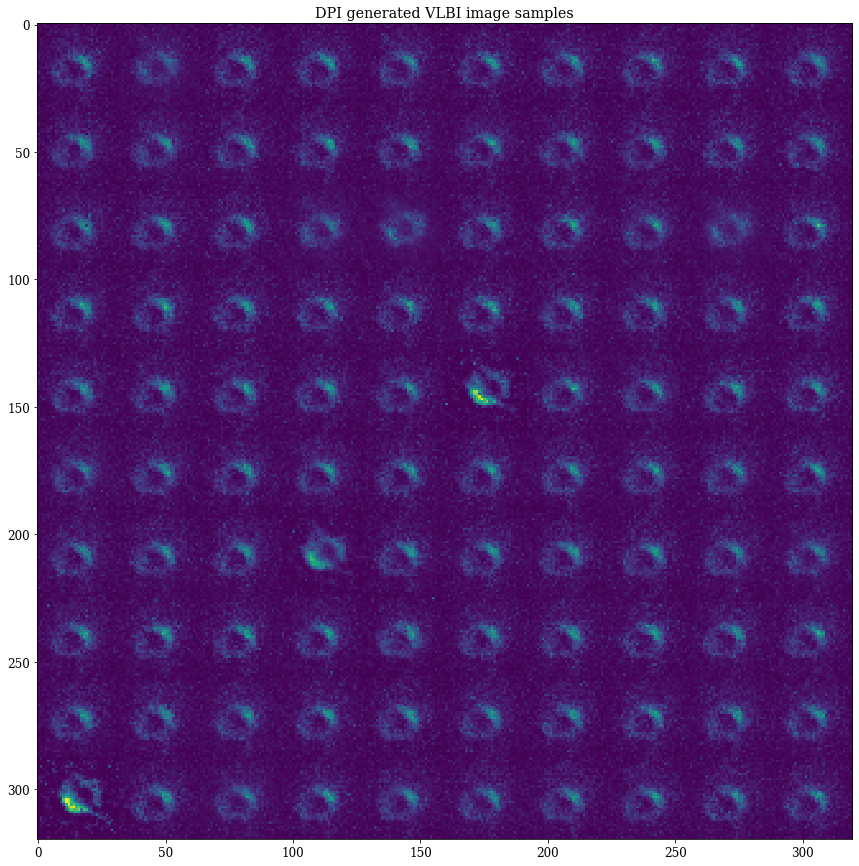

In [17]:
image_stitch = np.zeros((npix*10, npix*10))
for k in range(100):
    i = k//10
    j = k%10
    image_stitch[npix*i:npix*(i+1), npix*j:npix*(j+1)] = image[k]
plt.figure(figsize = (15,15)), plt.imshow(image_stitch)
plt.title('DPI generated VLBI image samples')

# Characterize multiple modes of image samples using t-SNE plot

In [18]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f985322ea50>)

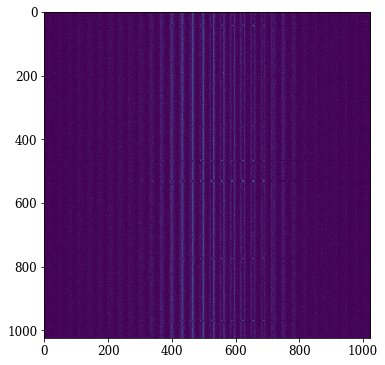

In [19]:
X = image.reshape((-1, npix*npix))
plt.figure(figsize= (6,6)), plt.imshow(X)

In [20]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X)

In [21]:
print(X_embedded.shape)

(1024, 2)


Text(0, 0.5, 't-SNE Dimension #2')

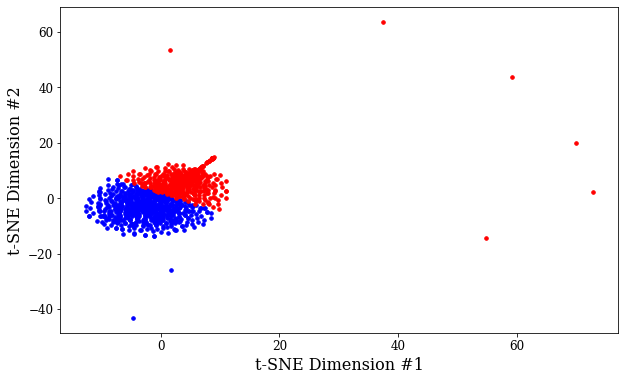

In [22]:
x = X_embedded[:, 0]
y = X_embedded[:, 1]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_embedded)

plt.figure(figsize=(10, 6)), plt.scatter(x[kmeans.labels_==0], y[kmeans.labels_==0], c='blue', marker='.', s=50)
plt.scatter(x[kmeans.labels_==1], y[kmeans.labels_==1], c='red', marker='.', s=50)
plt.xlabel('t-SNE Dimension #1', fontsize=16)
plt.ylabel('t-SNE Dimension #2', fontsize=16)

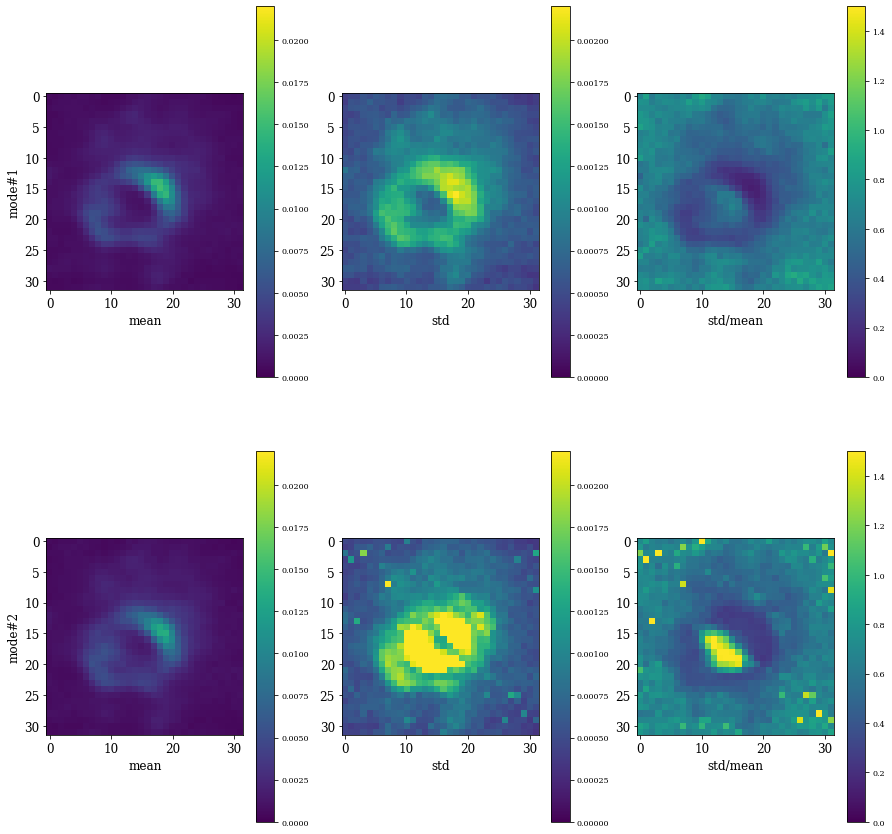

In [23]:
# plot mean and std of each mode
img_mean1 = np.mean(image[kmeans.labels_==0], 0)
img_std1 = np.std(image[kmeans.labels_==0], 0)
img_mean2 = np.mean(image[kmeans.labels_==1], 0)
img_std2 = np.std(image[kmeans.labels_==1], 0)

fig, axs = plt.subplots(2, 3, figsize=(15, 15))

# plot mode#1
im = axs[0, 0].imshow(img_mean1, vmin=0, vmax=2.2e-2)
axs[0, 0].set(ylabel='mode#1', xlabel='mean')
cbar = fig.colorbar(im, ax=axs[0, 0])
cbar.ax.tick_params(labelsize=8)

im = axs[0, 1].imshow(img_std1, vmin=0, vmax=2.2e-3)
axs[0, 1].set(ylabel='', xlabel='std')
cbar = fig.colorbar(im, ax=axs[0, 1])
cbar.ax.tick_params(labelsize=8)

im = axs[0, 2].imshow(img_std1 / img_mean1, vmin=0, vmax=1.5)
axs[0, 2].set(ylabel='', xlabel='std/mean')
cbar = fig.colorbar(im, ax=axs[0, 2])
cbar.ax.tick_params(labelsize=8)

# plot mode#2
im = axs[1, 0].imshow(img_mean2, vmin=0, vmax=2.2e-2)
axs[1, 0].set(ylabel='mode#2', xlabel='mean')
cbar = fig.colorbar(im, ax=axs[1, 0])
cbar.ax.tick_params(labelsize=8)

im = axs[1, 1].imshow(img_std2, vmin=0, vmax=2.2e-3)
axs[1, 1].set(ylabel='', xlabel='std')
cbar = fig.colorbar(im, ax=axs[1, 1])
cbar.ax.tick_params(labelsize=8)

im = axs[1, 2].imshow(img_std2 / img_mean2, vmin=0, vmax=1.5)
axs[1, 2].set(ylabel='', xlabel='std/mean')
cbar = fig.colorbar(im, ax=axs[1, 2])
cbar.ax.tick_params(labelsize=8)

for ax in axs.flat:
    ax.label_outer()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

In [24]:
z_samp = torch.randn(32, 32*32).to(device=device)
img_samp, logdet = img_generator.reverse(z_samp)
print(z_samp)
print(z_samp.shape)

tensor([[ 1.8375, -0.8296, -0.8761,  ...,  2.1190,  0.3724,  1.0528],
        [-1.6012,  0.7450,  0.9555,  ...,  0.0195,  0.4644,  0.2836],
        [-0.0838,  0.0574,  0.8753,  ...,  2.2306,  0.1129,  0.2021],
        ...,
        [ 0.1465,  1.4446,  2.1321,  ..., -1.0083, -0.7810,  1.1584],
        [-1.8815, -0.4111,  0.2250,  ..., -0.8935,  0.1699, -1.1102],
        [-1.5686,  0.9079, -0.4083,  ..., -0.3891, -1.4161,  0.6216]])
torch.Size([32, 1024])


In [25]:
random_samps, logdet = img_generator.forward(img_samp)

In [26]:
random_samps

tensor([[ 1.8375, -0.8296, -0.8761,  ...,  2.1189,  0.3724,  1.0528],
        [-1.6012,  0.7450,  0.9555,  ...,  0.0195,  0.4644,  0.2836],
        [-0.0838,  0.0574,  0.8753,  ...,  2.2306,  0.1129,  0.2021],
        ...,
        [ 0.1465,  1.4446,  2.1321,  ..., -1.0083, -0.7810,  1.1584],
        [-1.8815, -0.4111,  0.2250,  ..., -0.8935,  0.1699, -1.1102],
        [-1.5686,  0.9079, -0.4083,  ..., -0.3891, -1.4161,  0.6216]],
       grad_fn=<IndexBackward>)